In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
from tqdm import tqdm
import nltk
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!pip install contractions
import contractions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train_data = pd.read_csv('TrainData.csv').values
test = pd.read_csv('TestData_Inputs.csv').values
train_data[:10]

array([['worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom

In [3]:
import string
punctuation = '!"#$%&\'()*+,-/:;<=>?@[\]^_`{|}~'
table = str.maketrans('','',punctuation)

w = "wekfwknefkf//*1.,..[][']]['"
w.translate(table)
word_tokenize('helllo k.')

['helllo', 'k', '.']

In [4]:
np.random.seed(11)
train_d = train_data[:,0]
train_l = train_data[:,1]
test_d = test[:,1]
#test_l = test[:,1]
print(train_d.shape)
temp = list(zip(train_d, train_l))
np.random.shuffle(temp)
train_d, train_l = zip(*temp)

(1490,)


In [5]:
punctuation = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'
stop_words = set(['i','am','re','are','be','so','or','a','an','as','he','she','his','her','the','there','here','and','but','other','on','in','to','of','up','down','after','before','we','they','has','have', 'was','were','is','','it','how','that','at','go','is','do','will','shall','ve','if','may','might','by','s','o','d','t','my','might','all','out','for','ll'])
table = str.maketrans('','',punctuation)
train_p = []
test_p = []
train_tokens = []
for paragraph in train_d:
  tokens = contractions.fix(paragraph)
  temp = []
  for sentence in nltk.tokenize.sent_tokenize(tokens):
    if len(sentence)==0:
        continue
    #tokens = word_tokenize(tokens)
    token = [w.translate(table)  for w in sentence.split(' ') if len(w)>0]
    token = [w for w in token if w.isalpha()]
    token = [w for w in token if not w in stop_words]
    #print(token)
    temp.append(token)
    train_tokens += token
  train_p.append(temp)

for paragraph in test_d:
  tokens = contractions.fix(paragraph)
  temp = []
  for sentence in nltk.tokenize.sent_tokenize(tokens):
    if len(sentence)==0:
        continue
    #tokens = word_tokenize(tokens)
    token = [w.translate(table)  for w in sentence.split(' ') if len(w)>0 ]

    token = [w for w in token if w.isalpha()]
    token = [w for w in token if not w in stop_words]
    #print(token)
    temp.append(token)
  test_p.append(temp)

In [6]:
train_tokens[:20]

['us',
 'critics',
 'laud',
 'comedy',
 'sideways',
 'road',
 'trip',
 'comedy',
 'sideways',
 'had',
 'more',
 'praise',
 'heaped',
 'two',
 'us',
 'critics',
 'associations',
 'adding',
 'honours',
 'already']

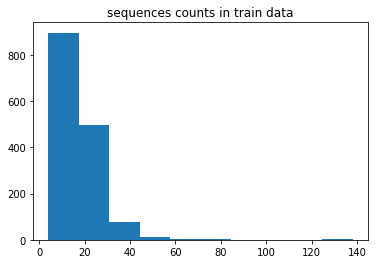

maximum sequence length: 138


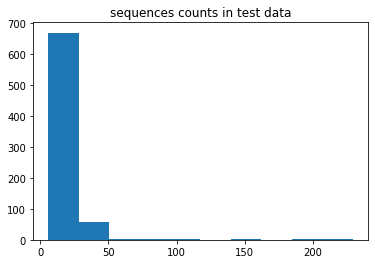

maximum sequence length: 229


In [7]:
plt.title('sequences counts in train data')
plt.hist([len(t) for t in train_p])
plt.show()
print(f"maximum sequence length: {max([len(t) for t in train_p])}")

plt.title('sequences counts in test data')
plt.hist([len(t) for t in test_p])
plt.show()
print(f"maximum sequence length: {max([len(t) for t in test_p])}")

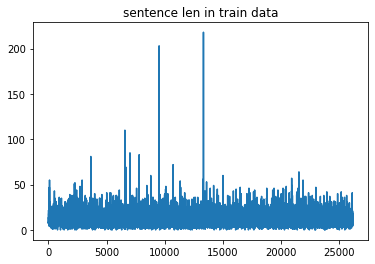

maximum sentence length: 218


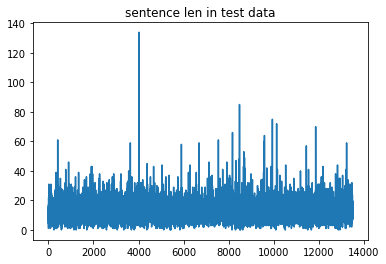

maximum sentence length: 134


In [8]:
plt.title('sentence len in train data')
hist = []
for paragraph in train_p:
  hist+=[len(t) for t in paragraph]
plt.plot(hist)
plt.show()
print(f"maximum sentence length: {max(hist)}")

plt.title('sentence len in test data')
hist = []
for paragraph in test_p:
  hist+=[len(t) for t in paragraph]
plt.plot(hist)
plt.show()
print(f"maximum sentence length: {max(hist)}")

In [9]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_tokens)
X_tok_train = [tokenizer.texts_to_sequences(paragraph) for paragraph in train_p]
X_tok_test = [tokenizer.texts_to_sequences(paragraph) for paragraph in test_p]
word_index = tokenizer.word_index
print("unique tokens except pad_token- "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1  #  pad_token at 0th index
print('vocab_size - '+str(vocab_size))
max_length = 25
X_padded_lines_train = [pad_sequences(paragraph, maxlen=max_length, padding='post') for paragraph in X_tok_train]
X_padded_lines_test = [pad_sequences(paragraph, maxlen=max_length, padding='post') for paragraph in X_tok_test]
#create word list from token using utf8 encoding 
#word_list = [word for words in processedLines for word in words]

unique tokens except pad_token- 24299
vocab_size - 24300


In [10]:
max_sen_length = 30
X_padded_train = pad_sequences(X_padded_lines_train, maxlen = max_sen_length, padding='post')
X_padded_test = pad_sequences(X_padded_lines_test, maxlen = max_sen_length, padding='post')

In [11]:
print('Train shape ::',X_padded_train.shape)
print('Test shape ::',X_padded_test.shape)

X_train = X_padded_train
X_test = X_padded_test

Train shape :: (1490, 30, 25)
Test shape :: (735, 30, 25)


In [12]:
le = LabelEncoder()
y_test = pd.read_excel('Assignment4_TestLabels.xlsx').values[:,2]
print(y_test.shape)
y_train = le.fit_transform(np.array(train_l))
y_test = le.transform(y_test)
num_classes=5

(735,)


In [13]:
class DAN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100):
        super(DAN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
    def forward(self,x):
        # x = [paragraphs, num_sentence, num_words]
        embed = self.embedding(x)
        embed_dan = torch.mean(x, dim = 2).unsqueeze(2)
        # embed_da  = [paragraphs, num_sentences, embed_dim]



In [ ]:
class DanCnn(nn.Module):
    def __init__(self,vocab_size,embed_dim,seq_len,output_dim):
        super(DanCnn, self).__init__()

        self.embedding = nn.Embedding(vocab_size,embed_dim)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(3,embed_dim)),
            #nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(seq_len-2,1), stride=1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(2,embed_dim)),
            #nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(seq_len-1,1),stride=1)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(6,embed_dim)),
            #nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(seq_len-5,1),stride=1)
        )
        
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=32)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=32, out_features=output_dim)
        
    def forward(self, x):
        # x = [batch num_sentence, num_words]
        embed = self.embedding(x)
        embed_dan = torch.mean(torch.mean(embed, dim = 2).squeeze(2),dim=1).squeeze(1)
        # embed_da  = [batch,num_sentences, embed_dim]
        # out1 = self.layer1(embed_dan).squeeze(-1).squeeze(-1)
        # out2= self.layer2(embed_dan).squeeze(-1).squeeze(-1)
        
        # out3 = self.layer3(embed_dan).squeeze(-1).squeeze(-1)

        # out4 = torch.cat((out1,out2,out3),dim=1)
        
        lin1 = self.fc1(embed_dan)
        '''lin1 = self.drop(lin1)
        lin2 = self.fc2(lin1)
        lin2 = self.drop(lin2)
        lin3 = self.fc3(lin2)'''
        lin3 = self.drop(lin1)
        lin4 = self.fc4(lin3)
        return lin4

embed_dim = 300
vocab_dim = vocab_size
max_sen_length = X_train.shape[1]
num_classes = 5
model = DanCnn(vocab_size=vocab_dim,embed_dim = embed_dim,seq_len=max_sen_length,output_dim=num_classes).to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
num_epochs =  100
batch_size = 2
size = X_train.shape[0]
d = int(size/batch_size)
val_size = int(0.2*X_train.shape[0])
X_train_b = np.array_split(X_train[val_size:,:,:],d)
y_train_b = np.array_split(y_train[val_size:],d)
train_loss = []
val_loss = []

X_val = X_train[:val_size,:,:]
y_val = y_train[:val_size] 
X_val1, y_val1 = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_val1, y_val1 = X_val1.to(device), y_val1.to(device)


train_acc = 0
train_accs = []
valid_accs = []
best_ac = 0

for epoch in range(num_epochs):
    
    batch_loss = 0
    n_samples = 0
    train_acc = 0
    
    for X_train1, y_train1 in zip(X_train_b,y_train_b):
        model.train()
        n_samples += X_train1.shape[0]
        X_train1, y_train1 = torch.from_numpy(X_train1), torch.from_numpy(y_train1)
        X_train1, y_train1 = X_train1.to(device), y_train1.to(device)
        
        # Forward pass 
        outputs = model(X_train1.long())
        loss = error(outputs, y_train1)
        batch_loss+=loss*X_train1.shape[0]
        train_acc += torch.sum(y_train1==torch.argmax(outputs,1)) 
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    print("No of epoch: {}, Training Loss: {} Acc: {}".format(epoch, batch_loss/n_samples,train_acc/n_samples))

    model.eval()

    output = model(X_val1.long())
    loss = error(output, y_val1)
    valid_acc = torch.sum(y_val1==torch.argmax(output,1))/y_val1.shape[0]
    print("Validation Loss: {} Acc: {}".format(loss.data,valid_acc))
    train_loss.append(batch_loss/n_samples)
    val_loss.append(loss)
    train_accs.append(train_acc/n_samples)
    valid_accs.append(valid_acc)
    if best_ac<valid_acc:
      best_ac = valid_acc
      torch.save(model,'model_dan.sav')

# ploting training loss per epochs
  
plt.title('training and validation loss per Epoch')
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.title('training and validation accuracy per Epoch')
plt.plot(train_accs,label='train')
plt.plot(valid_accs,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

No of epoch: 0, Training Loss: 1.6106826066970825 Acc: 0.22399328649044037
Validation Loss: 1.6005173921585083 Acc: 0.23489932715892792
No of epoch: 1, Training Loss: 1.6086597442626953 Acc: 0.23657718300819397
Validation Loss: 1.5909610986709595 Acc: 0.23489932715892792
No of epoch: 2, Training Loss: 1.5998833179473877 Acc: 0.23322147130966187
Validation Loss: 1.5900077819824219 Acc: 0.23489932715892792
No of epoch: 3, Training Loss: 1.5908292531967163 Acc: 0.25
Validation Loss: 1.5733301639556885 Acc: 0.23489932715892792
No of epoch: 4, Training Loss: 1.5779589414596558 Acc: 0.2567114233970642
Validation Loss: 1.5665661096572876 Acc: 0.23489932715892792
No of epoch: 5, Training Loss: 1.5692787170410156 Acc: 0.27684563398361206
Validation Loss: 1.5573182106018066 Acc: 0.23489932715892792
No of epoch: 6, Training Loss: 1.5540415048599243 Acc: 0.3087248206138611
Validation Loss: 1.5433671474456787 Acc: 0.23489932715892792
No of epoch: 7, Training Loss: 1.5437932014465332 Acc: 0.31291946

The model has 2,485,465 trainable parameters
No of epoch: 0, Training Loss: 0.00230586645193398 Acc: 1.0
Validation Loss: 0.8099813461303711 Acc: 0.899328887462616
The model has 2,485,465 trainable parameters
No of epoch: 1, Training Loss: 0.0024002871941775084 Acc: 0.9991610646247864
Validation Loss: 0.9110188484191895 Acc: 0.8959731459617615


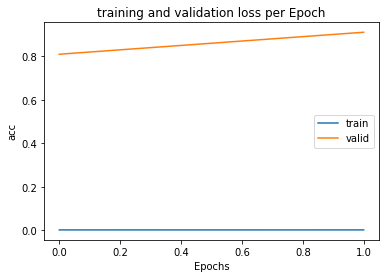

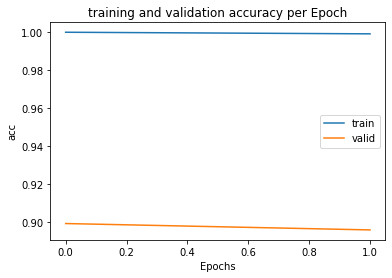

In [13]:
class TransformerCnn(nn.Module):
    def __init__(self,vocab_size,embed_dim,seq_len,output_dim,nheads,nlayers,dropout,device):
        super(TransformerCnn, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size,embed_dim,padding_idx = 0)
        encoder_layers = nn.TransformerEncoderLayer(d_model = embed_dim, nhead = nheads, dim_feedforward=64, dropout=dropout, batch_first=True, device=device)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=16)
        self.drop = nn.Dropout2d(0.25)
        '''self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)'''
        self.fc4 = nn.Linear(in_features=16, out_features=output_dim)
        
    def forward(self, x):
        # x = [batch, num_sentence, num_words]
        batch_size = x.shape[0]
        para_size = x.shape[1]
        sen_size = x.shape[2]
        embed_dim = self.embed_dim
        embed = self.embedding(x)
        # embed = [batch, num_sentence, num_words, embed_dim]
        embed_trans = embed.reshape(batch_size*para_size,sen_size,embed_dim)
        # embed_trans = [batch*num_sentence, num_words, embed_dim]
        embed_trans = self.transformer_encoder(embed_trans)
        embed_trans = embed_trans.reshape(batch_size,para_size,sen_size,embed_dim)
        # embed_trans = [batch, num_sentence, num_words, embed_dim]
        embed_trans = torch.sum(embed_trans, dim = 2).squeeze(2)
        # embed_trans  = [batch, num_sentences, embed_dim]
        embed_trans = torch.mean(embed_trans,dim = 1).squeeze(1)
        # embed_trans  = [batch, embed_dim]
        
        lin1 = self.fc1(embed_trans)
        '''lin1 = self.drop(lin1)
        lin2 = self.fc2(lin1)
        lin2 = self.drop(lin2)
        lin3 = self.fc3(lin2)'''
        lin3 = self.drop(lin1)
        lin4 = self.fc4(lin3)
        return lin4

embed_dim = 100
vocab_dim = vocab_size
max_sen_length = X_train.shape[1]
num_classes = 5
n_head = 5
dropout = 0.4
n_layer = 1
# model = TransformerCnn(vocab_size = vocab_dim, embed_dim = embed_dim, seq_len = max_sen_length, output_dim = num_classes, nheads = n_head, nlayers = n_layer, dropout = dropout,device=device).to(device)
model = torch.load('model_transformer.sav')
error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs =  2
batch_size = 2
size = X_train.shape[0]
d = int(size/batch_size)
val_size = int(0.2*X_train.shape[0])
X_train_b = np.array_split(X_train[val_size:,:,:],d)
y_train_b = np.array_split(y_train[val_size:],d)
train_loss = []
val_loss = []

X_val = X_train[:val_size,:,:]
y_val = y_train[:val_size] 
X_val1, y_val1 = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_val1, y_val1 = X_val1.to(device), y_val1.to(device)
X_train_d, y_train_d = [torch.from_numpy(X_train_b[i]).to(device) for i in range(len(X_train_b))], [torch.from_numpy(y_train_b[i]).to(device) for i in range(len(y_train_b))]

train_acc = 0
train_accs = []
valid_accs = []
best_ac = 0
for epoch in range(num_epochs):
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {count_parameters(model):,} trainable parameters')
    batch_loss = 0
    n_samples = 0
    train_acc = 0
    
    for X_train1, y_train1 in zip(X_train_d,y_train_d):
        model.train()
        n_samples += X_train1.shape[0]
        # X_train1, y_train1 = torch.from_numpy(X_train1), torch.from_numpy(y_train1)
        #X_train1, y_train1 = X_train1.to(device), y_train1.to(device)

        # Forward pass 
        outputs = model(X_train1)
        loss = error(outputs, y_train1)
        batch_loss+=loss*X_train1.shape[0]
        train_acc += torch.sum(y_train1==torch.argmax(outputs,1)) 
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        torch.cuda.empty_cache()
    print("No of epoch: {}, Training Loss: {} Acc: {}".format(epoch, batch_loss/n_samples,train_acc/n_samples))

    model.eval()
    output = model(X_val1)
    loss = error(output, y_val1)
    valid_acc = torch.sum(y_val1==torch.argmax(output,1))/y_val1.shape[0]
    print("Validation Loss: {} Acc: {}".format(loss.data,valid_acc))
    train_loss.append(batch_loss/n_samples)
    val_loss.append(loss)
    train_accs.append(train_acc/n_samples)
    valid_accs.append(valid_acc)
    if best_ac<valid_acc:
      best_ac = valid_acc
      torch.save(model,'model_transformer.sav')

# ploting training loss per epochs
  
plt.title('training and validation loss per Epoch')
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

plt.title('training and validation accuracy per Epoch')
plt.plot(train_accs,label='train')
plt.plot(valid_accs,label='valid')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show() 

In [14]:
from sklearn.metrics import f1_score,classification_report
X_test1, y_test1= torch.from_numpy(X_test), torch.from_numpy(y_test)
X_test1,y_test1 = X_test1.to(device), y_test1.to(device)
model = torch.load('model_transformer.sav')
model.eval()
output = model(X_test1)
#loss = error(output, y_test1)
test_acc = torch.sum(y_test1==torch.argmax(output,1))/y_test1.shape[0]
y_pred = le.inverse_transform(torch.argmax(output,1).detach().cpu().numpy())
#df = pd.DataFrame({'ArticleId':list(pd.read_csv('TestData_Labels.csv').values[:,0]),'Category':list(y_pred)})
#df.to_csv('result1.csv',index=False)
print("Using USE Test  Acc: {}, f1-score: {}".format(test_acc,f1_score(y_test,torch.argmax(output,1).detach().cpu().numpy(),average='micro')))
print(classification_report(y_test,torch.argmax(output,1).detach().cpu().numpy()))

Using USE Test  Acc: 0.8721088767051697, f1-score: 0.8721088435374149
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       176
           1       0.70      0.96      0.81       113
           2       0.85      0.91      0.88       143
           3       0.94      0.90      0.92       168
           4       0.96      0.79      0.87       135

    accuracy                           0.87       735
   macro avg       0.88      0.88      0.87       735
weighted avg       0.89      0.87      0.87       735



In [15]:
from sklearn.metrics import f1_score,classification_report
X_test1, y_test1= torch.from_numpy(X_test), torch.from_numpy(y_test)
X_test1,y_test1 = X_test1.to(device), y_test1.to(device)
model = torch.load('model_dan.sav')
model.eval()
output = model(X_test1)
#loss = error(output, y_test1)
test_acc = torch.sum(y_test1==torch.argmax(output,1))/y_test1.shape[0]
y_pred = le.inverse_transform(torch.argmax(output,1).detach().cpu().numpy())
#df = pd.DataFrame({'ArticleId':list(pd.read_csv('TestData_Labels.csv').values[:,0]),'Category':list(y_pred)})
#df.to_csv('result1.csv',index=False)
print("Using USE Test  Acc: {}, f1-score: {}".format(test_acc,f1_score(y_test,torch.argmax(output,1).detach().cpu().numpy(),average='micro')))
print(classification_report(y_test,torch.argmax(output,1).detach().cpu().numpy()))

Using USE Test  Acc: 0.9510204195976257, f1-score: 0.9510204081632653
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       176
           1       0.95      0.96      0.96       113
           2       0.97      0.92      0.95       143
           3       0.99      0.97      0.98       168
           4       0.91      0.99      0.95       135

    accuracy                           0.95       735
   macro avg       0.95      0.95      0.95       735
weighted avg       0.95      0.95      0.95       735

